In [3]:
import os
import glob
from pathlib import Path
from tqdm import tqdm
import argparse
import scipy.io
import numpy as np
import SimpleITK as sitk

import calc_t1map_py as t1_py

In [5]:
npy = '../results/MOLLI_pre/group/rank_10_10_10/jointcorrelation/l2/image_loss_weight1/weight0.3/bspline/cps4_svfsteps7_svfscale1/e100/test_MOLLI_pre/round3/moved/0387056_20140423_MOLLI_3.npy'
frames = np.load(npy).transpose(1, 2, 0)
tvec = [146,248,350,985,1006,1089,1719,1809,1847,2751,3618]
tvec = np.array(tvec)

print(frames.shape, tvec.shape)

(224, 224, 11) (11,)


In [6]:
t1_params_pre = t1_py.calculate_T1map(frames, tvec)

a = t1_params_pre[:, :, 0]
b = t1_params_pre[:, :, 1]
c = t1_params_pre[:, :, 2]
t1 = (1 / b) * (a / (a + c) - 1)

/opt/homebrew/Caskroom/miniconda/base/envs/voxelmorph/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [8]:
np.max(t1)

168641494.98311484

(-0.5, 223.5, 223.5, -0.5)

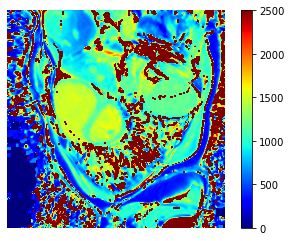

In [14]:
import matplotlib.pyplot as plt
plt.imshow(t1, cmap='jet', vmin=0, vmax=2000)
plt.colorbar()
plt.axis('off')